In [1]:
from pystats_utils.utils.patient import Patient

import pandas as pd

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Mortality_31d"] == "no"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))

keys = ["Days", "Changes", "Atbs"]
times = ["Total", "Pre", "Post"]
groups = {"Amikacin"    : "Aminoglicosidos",
          "Gentamicin"  : "Aminoglicosidos",
          "Tigecycline" : "Tigecycline",
          "Colistin"    : "Polimixinas",
          "Polymyxin"   : "Polimixinas",
          "Caz-avi"     : "Caz-avi"}

result = {key : {time : {group : [] for group in groups.values()} for time in times} for key in keys}

for patient in patients:

    allAtbs = [element for step in patient.translateTreatmentLine(only = "active",
                                                                condensed = True,
                                                                days = False) for element in step if element != "None"]

    for atb in groups:
        if atb in allAtbs:

            # Days
            dayTreatment = patient.translateTreatmentLine(only = "active",
                                                          condensed = False,
                                                          days = False)
            for index, day in enumerate(dayTreatment):

                if atb in day:
                    result["Days"]["Total"][groups[atb]].append(len(dayTreatment))
                    result["Days"]["Pre"][groups[atb]].append(index)
                    result["Days"]["Post"][groups[atb]].append(len(dayTreatment) - index - 1)
                    break

            # Changes
            changeTreatment = patient.translateTreatmentLine(mergeInactive = True,
                                                             condensed = True,
                                                             days = False)
            for index, step in enumerate(changeTreatment):

                if atb in step:
                    result["Changes"]["Total"][groups[atb]].append(len(changeTreatment))
                    result["Changes"]["Pre"][groups[atb]].append(index)
                    result["Changes"]["Post"][groups[atb]].append(len(changeTreatment) - index - 1)
                    break

            # Changes
            atbsTreatment = patient.translateTreatmentLine(condensed = True,
                                                           mergeInactive = False,
                                                           days = False)
            for index, step in enumerate(atbsTreatment):
                if f"{atb}_S" in step:

                    allAtbs = set([element for step in atbsTreatment for element in step if element != "None"])

                    result["Atbs"]["Total"][groups[atb]].append(len(allAtbs) - 1)

                    preAtbs = set([element for step in atbsTreatment[:index] for element in step if element != "None"])
                    if f"{atb}_s" in preAtbs: preAtbs.remove(f"{atb}_s")

                    result["Atbs"]["Pre"][groups[atb]].append(len(preAtbs))

                    posAtbs = set([element for step in atbsTreatment[index + 1:] for element in step if element != "None"])
                    if f"{atb}_s" in posAtbs: posAtbs.remove(f"{atb}_s")

                    result["Atbs"]["Post"][groups[atb]].append(len(posAtbs))
                    break

import pandas as pd

template = {}

flag = True

for key, value in result.items():
    for time, value in value.items():
        aux = []

        names = []

        for group, values in value.items():
            aux += values
            names += [group] * len(values)

        if flag:
            template["group"] = names

        template[f"{key}_{time}"] = aux

data = pd.DataFrame(template)
data

,group,Days_Total,Days_Pre,Days_Post,Changes_Total,Changes_Pre,Changes_Post,Atbs_Total,Atbs_Pre,Atbs_Post
0,Aminoglicosidos,21,0,20,4,0,3,3,0,3
1,Aminoglicosidos,27,0,26,4,0,3,3,0,4
2,Aminoglicosidos,9,0,8,2,0,1,2,0,3
3,Aminoglicosidos,23,1,21,6,1,4,4,1,4
4,Aminoglicosidos,27,0,26,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
110,Caz-avi,11,0,10,1,0,0,0,0,0
111,Caz-avi,25,0,24,2,0,1,1,0,1
112,Caz-avi,18,0,17,2,0,1,1,0,1
113,Caz-avi,6,0,5,1,0,0,1,0,0


In [5]:
set(data["group"])

{'Aminoglicosidos', 'Caz-avi', 'Polimixinas', 'Tigecycline'}

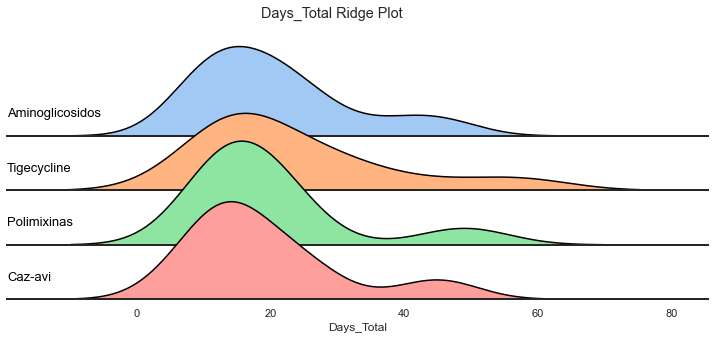

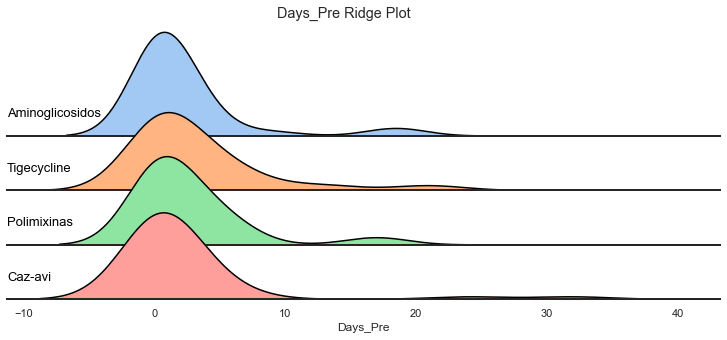

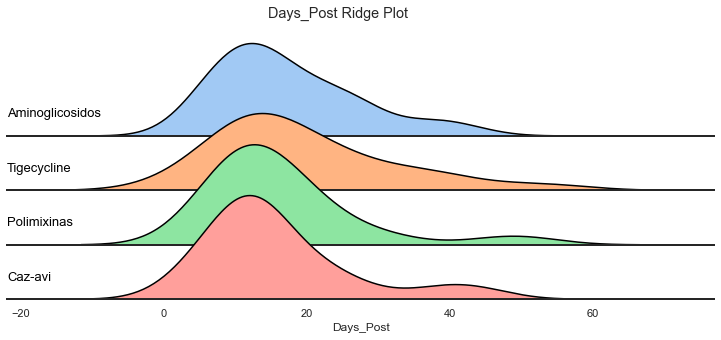

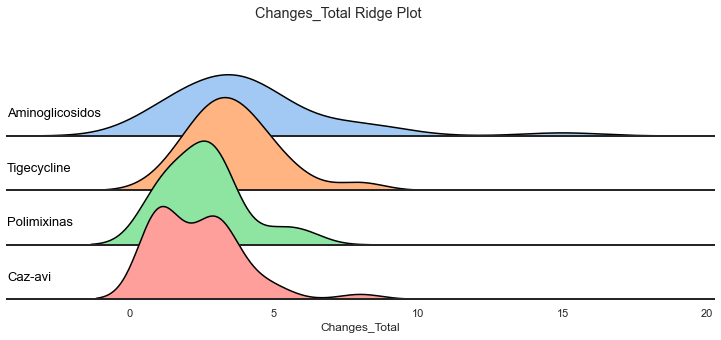

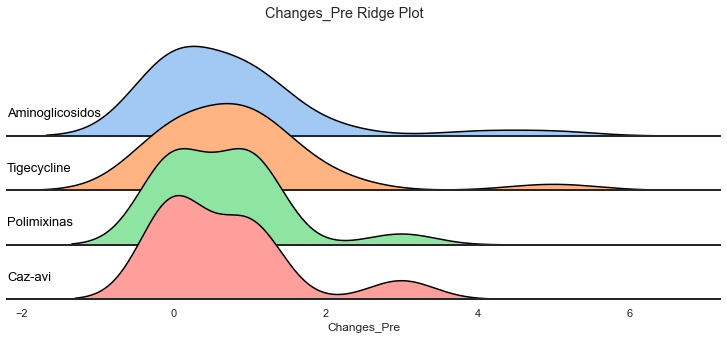

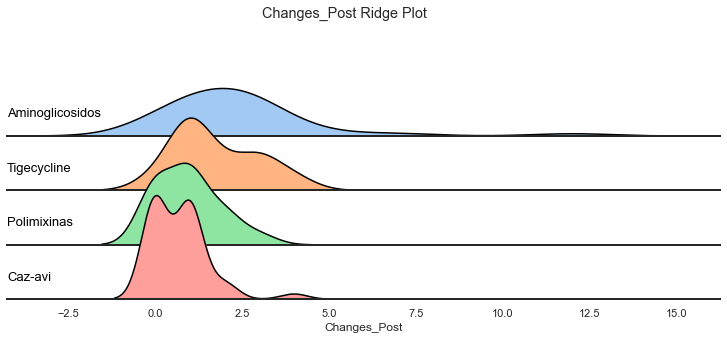

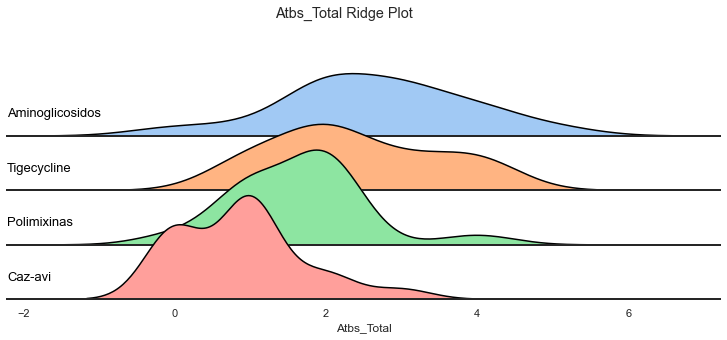

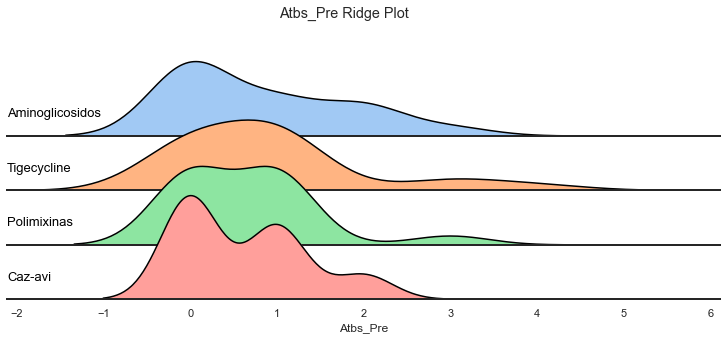

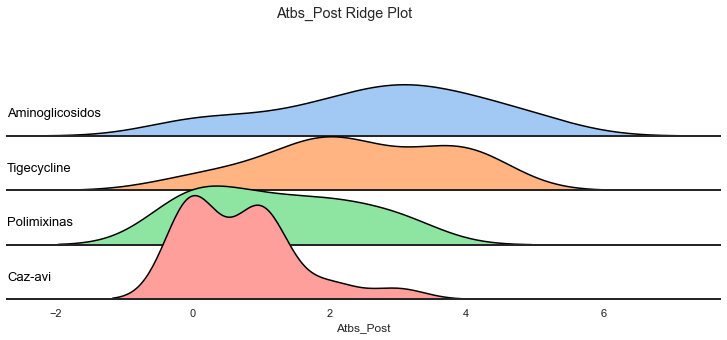

In [8]:
import pandas as pd
import numpy as np

from pystats_utils.plot import RidgePlot
from pystats_utils.test.value_comparison import MannWhitneyUTest

template = {"Variable"        : [],
            "All"             : [],
            "Aminoglicosidos" : [],
            "Polimixinas"     : [],
            "Tigecycline"     : [],
            "Caz-avi"         : [],
            "Caz-avi vs. Aminoglicosidos" : [],
            "Caz-avi vs. Polimixinas"     : [],
            "Caz-avi vs. Tigecycline"     : []}

for column in data:

    if "group" != column:

        plot = RidgePlot(dataframe = data,
                         classVariable = "group",
                         targetVariable = column).run()

        plot.savefig(f"{column}.png", dpi = 300)


        result = MannWhitneyUTest(dataframe = data,
                                  classVariable = "group",
                                  targetVariable = column).run()

        template["Variable"].append(column)
        template["All"].append("{:.2f} ({:.2f} - {:.2f})".format(np.mean(data[column]),
                                                                 np.percentile(data[column], 25),
                                                                 np.percentile(data[column], 75)))

        for group in ["Aminoglicosidos", "Polimixinas", "Tigecycline", "Caz-avi"]:

            template[group].append("{:.2f} ({:.2f} - {:.2f})".format(np.mean(data[data["group"] == group][column]),
                                                                     np.percentile(data[data["group"] == group][column], 25),
                                                                     np.percentile(data[data["group"] == group][column], 75)))

        for pvalue in result.pvalue:

            if "Caz-avi" in pvalue:
                if "Aminoglicosidos" in pvalue: template["Caz-avi vs. Aminoglicosidos"].append("{:.3f}".format(result.pvalue[pvalue]))
                if "Polimixinas" in pvalue: template["Caz-avi vs. Polimixinas"].append("{:.3f}".format(result.pvalue[pvalue]))
                if "Tigecycline" in pvalue: template["Caz-avi vs. Tigecycline"].append("{:.3f}".format(result.pvalue[pvalue]))


result = pd.DataFrame(template)



In [10]:
result.rename(columns = {"All" : f"All (N={len(data)})",
                         "Aminoglicosidos" : f"Aminoglicosidos (N={len(data[data['group'] == 'Aminoglicosidos'])})",
                         "Polimixinas" : f"Polimixinas (N={len(data[data['group'] == 'Polimixinas'])})",
                         "Tigecycline" : f"Tigecycline (N={len(data[data['group'] == 'Tigecycline'])})",
                         "Caz-avi" : f"Caz-avi (N={len(data[data['group'] == 'Caz-avi'])})"})

,Variable,All (N=115),Aminoglicosidos (N=34),Polimixinas (N=17),Tigecycline (N=23),Caz-avi (N=41),Caz-avi vs. Aminoglicosidos,Caz-avi vs. Polimixinas,Caz-avi vs. Tigecycline
0,Days_Total,20.63 (12.50 - 24.50),20.62 (12.25 - 26.00),19.94 (13.00 - 21.00),23.65 (14.50 - 28.50),19.24 (12.00 - 23.00),0.530,0.719,0.170
1,Days_Pre,2.54 (0.00 - 2.50),2.29 (0.00 - 2.00),2.59 (0.00 - 3.00),3.22 (0.00 - 4.50),2.34 (0.00 - 2.00),0.668,0.420,0.165
2,Days_Post,17.10 (10.00 - 21.00),17.32 (10.50 - 23.25),16.35 (10.00 - 20.00),19.43 (11.50 - 24.50),15.90 (10.00 - 19.00),0.446,0.810,0.199
3,Changes_Total,3.17 (2.00 - 4.00),4.15 (2.25 - 5.00),2.59 (2.00 - 3.00),3.61 (3.00 - 4.00),2.37 (1.00 - 3.00),0.000,0.517,0.001
4,Changes_Pre,0.74 (0.00 - 1.00),0.76 (0.00 - 1.00),0.65 (0.00 - 1.00),0.87 (0.00 - 1.00),0.68 (0.00 - 1.00),0.869,0.909,0.383
5,Changes_Post,1.43 (0.00 - 2.00),2.38 (1.00 - 3.00),0.94 (0.00 - 1.00),1.74 (1.00 - 3.00),0.68 (0.00 - 1.00),0.000,0.267,0.000
6,Atbs_Total,1.82 (1.00 - 3.00),2.65 (2.00 - 3.00),1.65 (1.00 - 2.00),2.39 (2.00 - 3.00),0.88 (0.00 - 1.00),0.000,0.002,0.000
7,Atbs_Pre,0.74 (0.00 - 1.00),0.82 (0.00 - 1.75),0.65 (0.00 - 1.00),0.91 (0.00 - 1.00),0.61 (0.00 - 1.00),0.482,0.940,0.365
8,Atbs_Post,1.73 (0.00 - 3.00),2.74 (2.00 - 4.00),1.24 (0.00 - 2.00),2.43 (2.00 - 4.00),0.71 (0.00 - 1.00),0.000,0.107,0.000


In [11]:
result.to_excel("treatment_comparation.xlsx")

In [14]:
from pystats_utils.utils.patient import Patient

import pandas as pd

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))

In [70]:
result = {}

for patient in patients:

    result[patient.pt] = {}

    treatmentLine = patient.translateTreatmentLine(condensed = False,
                                                   only = "active",
                                                   days = 38)

    count = 0
    flag = False
    for index, day in enumerate(treatmentLine):
        if day != {"None"}:
            flag = True
            if "Caz-avi" in day and not "start" in result[patient.pt]:
                result[patient.pt]["start"] = count
            if "start" in result[patient.pt] and not "Caz-avi" in day: result[patient.pt]["stop"] = count

        if flag: count += 1

    result[patient.pt]["Cohort"] = patient.cohort_cazavi

    if not "start" in result[patient.pt]: result[patient.pt]["start"] = 0
    if not "stop" in result[patient.pt]: result[patient.pt]["stop"] = 31

template = {"Pt" : [],
            "time" : [],
            "Cohort_Cazavi" : []}

randomStart = 0
notStart = 0

for pt, values in result.items():
    start, stop, cohort = values["start"], values["stop"], values["Cohort"]

    if cohort == "no":
        template["Pt"].append(pt)
        template["time"].append(31)
        template["Cohort_Cazavi"].append("no")

    else:

        if start == 0:
            notStart += 1
            template["Pt"].append(pt)
            template["time"].append(0)
            template["Cohort_Cazavi"].append("yes")

        else:
            randomStart += 1
            template["Pt"].append(pt)
            template["time"].append(0)
            template["Cohort_Cazavi"].append("no")

            template["Pt"].append(pt)
            template["time"].append(start)
            template["Cohort_Cazavi"].append("yes")

        if stop != 31:
            #print("Random stop", pt)
            template["Pt"].append(pt)
            template["time"].append(stop)
            template["Cohort_Cazavi"].append("no")

info = pd.DataFrame(template)

notStart, randomStart

(52, 31)

In [77]:
import pandas as pd

dataframe = pd.read_excel("./test/database/database.xlsx")
workDataframe = dataframe[dataframe["Cohort_Treatment"] == "yes"]

from lifelines.utils import to_long_format

auxWorkDataframe = to_long_format(workDataframe, duration_col = "Time2death_31d_alt")

from lifelines.utils import add_covariate_to_timeline

extendendData = add_covariate_to_timeline(auxWorkDataframe, info,
                                          duration_col = "time",
                                          id_col = "Pt",
                                          event_col = "Mortality_31d")

extendendData["Mortality_31d"] = extendendData["Mortality_31d"].replace("no", False).replace("yes", True)

Iteration 1: norm_delta = 0.15107, step_size = 0.95000, ll = -600.00947, newton_decrement = 1.94665, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00506, step_size = 0.95000, ll = -598.08785, newton_decrement = 0.00224, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00025, step_size = 0.95000, ll = -598.08562, newton_decrement = 0.00001, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00001, step_size = 1.00000, ll = -598.08561, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 4 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 185 periods, 149 subjects, 149 events>
         event col = 'Mortality_31d'
number of subjects = 149
 number of periods = 185
  number of events = 149
partial log-likelihood = -598.09
  time fit was run = 2022-12-09 11:45:19 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
Cohort_Cazavi  -0.16       0.85       0.16            -0.49             0.16                 0.62                 1.17
ICS_SOT_score   0.03       1.03       0.02            -0.01             0.06                 0.99                 1.06

                cmp to     z    p   -log2(p)
covariate                                   
Cohort_Cazavi     0.00 -1.00 0.32       1.65
ICS_SOT_score     0.00  1.64 0.10       3.30
---
Partial AIC = 1200.17
log-likelihood ratio test = 3.85 on 2 df
-log2(p) of ll-ratio test = 2.78

<AxesSubplot:xlabel='log(HR) (95% CI)'>

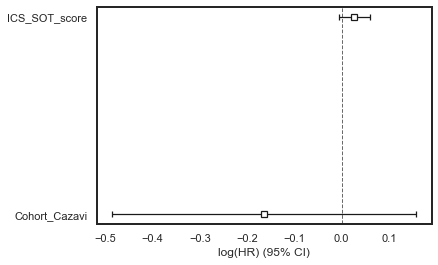

In [88]:
from lifelines import CoxTimeVaryingFitter
from pystats_utils.data_operations import reduceDataframe

extendendDataAux = reduceDataframe(extendendData,
                               "Pt", "Mortality_31d",
                               "start", "stop",
                               "Cohort_Cazavi",
                               "ICS_SOT_score")
#                              "Age",
#                              "ps_cvsb")

extendendDataAux["Cohort_Cazavi"] = extendendDataAux["Cohort_Cazavi"].replace("no", False).replace("yes", True)

ctv = CoxTimeVaryingFitter(penalizer=0.0)
ctv.fit(extendendDataAux,
        id_col= "Pt",
        event_col = "Mortality_31d",
        start_col="start",
        stop_col="stop",
        show_progress=True)
ctv.print_summary()
ctv.plot()

In [85]:
extendendDataAux.to_excel("test.xlsx")

In [ ]:
import pandas as pd

dataframe = pd.read_excel("./test/database/database.xlsx")
workDataframe = dataframe[dataframe["Cohort_Treatment"] == "yes"]

from pystats_utils.test.multivariant import CoxPhRegression

targetVariable = ["Gender",
                   "Age",
                   "ICS_SOT_score",
                   "Cohort_Cazavi",
                   "ps_cvsb"]

result = CoxPhRegression(dataframe = workDataframe,
                         eventVariable = "Mortality_31d",
                         timeVariable = "Time2death_31d",
                         targetVariable = targetVariable).run()

result.params.to_excel("tabla_4a_params_raw.xlsx")
result.summary.to_excel("tabla_4a_metrics_raw.xlsx")
result.params